In [1]:
import cv2
import numpy as np
from IPython.display import display
from PIL import Image

In [3]:
def read_video_to_array(fname, grayscale = True):
  cap = cv2.VideoCapture(fname)
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))
  fc = 0
  ret = True
  while (fc < frameCount  and ret):
      ret, buf[fc] = cap.read()
      fc += 1
  cap.release()  # release capturing of video
  print(f"Found {frameCount} many image frames in the video {fname}")

  if grayscale:
    return buf[:, :, :, 0].astype(np.float64) / 255   # make values between 0 and 1
  else:
    return buf.astype(np.float64) / 255  # make values between 0 and 1

In [9]:
# image display function
def display_image(arr, scale_factor = 1):
  # ensure that the image scales to 0 to 255, so do a linear transformation
  arr_min = arr.min()
  arr_max = arr.max()
  if arr_min < 0:
    arr2 = (arr - arr_min)/(arr_max - arr_min) * 255
  elif arr_max > 255:
    arr2 = arr/arr_max * 255
  else:
    arr2 = arr * 255
  im = Image.fromarray(np.ceil(arr2).astype(np.uint8))
  w, h = im.size
  display(im.resize((scale_factor * w,  scale_factor * h)))

## Working with Demo Video

In [5]:
vid = read_video_to_array('./data/demo.avi')
vid.shape

Found 51 many image frames in the video ./data/demo.avi


(51, 48, 48)

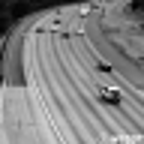

In [10]:
display_image(vid[40], scale_factor = 3)

In [12]:
# do the transformation X matrix
X = vid.reshape((vid.shape[0], -1)).T   # rowwise pixels, columnwise time
U, s, Vt = np.linalg.svd(X, full_matrices = False)  # do the SVD

rank = 1
L = U[:, :rank].reshape(-1, rank) @ np.diag(s[:rank]).reshape(rank, rank) @ Vt[:rank, :].reshape(rank, -1)
S = X - L  # do the L + S decomposition

vidbg = L.T.reshape(vid.shape)
vidfg = S.T.reshape(vid.shape)

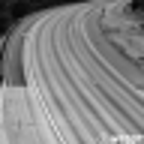

In [14]:
display_image(vidbg[40], scale_factor = 3)

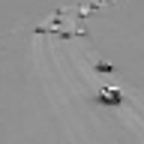

In [13]:
display_image(vidfg[40], scale_factor = 3)

Adding camera tampering

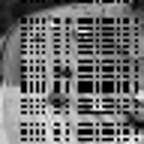

In [39]:
vid2 = vid.copy()
tamper_size = 30
vid2[np.ix_(range(5, 10), np.random.choice(47, size = tamper_size), np.random.choice(47, size = tamper_size))] = 0

display_image(vid2[5], scale_factor = 3)

In [40]:
# do svd again

# do the transformation X matrix
X = vid2.reshape((vid2.shape[0], -1)).T   # rowwise pixels, columnwise time
U, s, Vt = np.linalg.svd(X, full_matrices = False)  # do the SVD

rank = 1
L = U[:, :rank].reshape(-1, rank) @ np.diag(s[:rank]).reshape(rank, rank) @ Vt[:rank, :].reshape(rank, -1)
S = X - L  # do the L + S decomposition

vidbg = L.T.reshape(vid2.shape)
vidfg = S.T.reshape(vid2.shape)

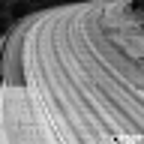

In [41]:
display_image(vidbg[15], scale_factor = 3)

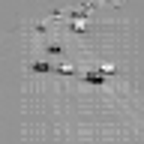

In [42]:
display_image(vidfg[15], scale_factor = 3)

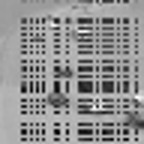

In [50]:
display_image(vidfg[5], scale_factor = 3)

In [44]:
# apply robust svd
from decompy.matrix_factorization import RobustSVDDensityPowerDivergence

In [45]:
%%time

# do the transformation X matrix
X = vid2.reshape((vid2.shape[0], -1)).T   # rowwise pixels, columnwise time

rank = 1
ss = RobustSVDDensityPowerDivergence(alpha = 0.5).decompose(X, rank = rank)
s2 = ss.singular_values(False)
U2, V2 = ss.singular_vectors('both')

L2 = U2[:, :rank].reshape(-1, rank) @ np.diag(s2[:rank]).reshape(rank, rank) @ V2.T[:rank, :].reshape(rank, -1)
S2 = X - L2  # do the L + S decomposition

vidbg2 = L2.T.reshape(vid2.shape)
vidfg2 = S2.T.reshape(vid2.shape)

CPU times: total: 29.8 s
Wall time: 35.6 s


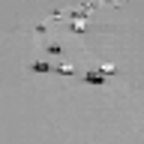

In [47]:
display_image(vidfg2[15], scale_factor = 3)

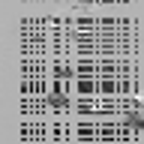

In [49]:
display_image(vidfg2[5], scale_factor = 3)